# Ex7 - Descrição e transformações de modelos

Nesta atividade, vocês vão exercitar os conceitos de descrição de um modelo e de transformações geométricas. Para evitar erros de execução, utilize apenas uma célula de código para cada parte desta atividade.

### Parte 1 - Criando uma malha de triângulos a partir de uma equação 

Complete a definição da função create_circle(fatias, raio) para criar uma malha triangular de um modelo circular centrado na origem a partir da equação paramétrica do círculo, como mostra a figura abaixo. O parâmetro 'fatias' é o número de divisões do modelo.

$x = raio * \cos (angle)$

$y = raio * \sin (angle)$

Os vértices podem ser definidos de duas maneiras. A primeira é utilizando apenas um vetor contendo as posições dos vértices dos triângulos. E a outra é utilizando dois vetores, um contendo as posições dos vértices e o outro contendo os índices dos vértices dos triângulos. Perceba que o recurso de culling do OpenGL está ativado. Então, a orientação dos vértices dos triângulos deve ser no sentido anti-horário. Escolha a primitiva de triângulo que achar mais adequada. Além da primitiva de triângulo escolhida, teste como o seu modelo se comporta ao utilizar outras primitivas, como linhas ou pontos. Você pode utilizar múltiplos viewports para mostrar os resultados. Você pode usar como base o notebook ([25_Formas_de_especificar_um_modelo](25_Formas_de_especificar_um_modelo.ipynb))

![title](cg/images/ex7_image.png)

In the following code, we experiment with rendering a circle with several different primitives:

In [22]:
import numpy as np
import OpenGL.GL as gl
from PyQt5 import QtOpenGL
from PyQt5.QtWidgets import QApplication

from cg.shader_programs.SimpleShaderProgram_v2 import SimpleShaderProgram
from cg.renderers.ModelRenderer_v2 import ModelRenderer

#Method for generating arrays for generating circle
def create_circle(slices, radius):
    
    vertex_positions = np.array([0,0,0,1]) # center of circle
    
    z = 0 #Z axis coordinate always 0
    w = 1 #W always 1
    
    j=0 #counting variable
    for i in range(0,int(360+360/slices),int(360/slices)): #Rotate around origin in intervals of 360/slices degrees
        x = radius*np.cos(i*(np.pi)/180) #generate X coordinate (must use radians)
        y = radius*np.sin(i*(np.pi)/180) #generate Y coordinate (must use radians)
        vertex_positions = np.append(vertex_positions, [x,y,z,w]) #append new vertex coordinates to positions array
        if j==0: vertex_indices = np.array([0,j+1,j+2], dtype=np.uint32) #if first itteration create array
        else: vertex_indices = np.append(vertex_indices, [0,j+1,j+2]) #if not, append to array
        j+=1

    vertex_indices = vertex_indices.astype('uint32') #guarantee array type, must be uint32
    vertex_positions = vertex_positions.astype('float32') #guarantee array type, must be float32
    
    return vertex_positions, vertex_indices



class MyWidget(QtOpenGL.QGLWidget):
    def initializeGL(self):
        
        # generate triangle fan arrays
        circle_mesh_positions, circle_mesh_indices = create_circle(30, 0.7)
#        print(circle_mesh_positions)       #
#        print(circle_mesh_positions.dtype) ## Used for debugging
#        print(circle_mesh_indices)         ## create_circle
#        print(circle_mesh_indices.dtype)   #
        
        #creates object responsible for loading data onto the GPU and rendering it
        self.circleRenderer = ModelRenderer(circle_mesh_positions, vertex_indices=circle_mesh_indices, 
                                            primitive=ModelRenderer.TRIANGLE_FAN)
        
        #with other primitives to see difference
        self.lineRenderer = ModelRenderer(circle_mesh_positions, vertex_indices=circle_mesh_indices, 
                                            primitive=ModelRenderer.LINES)
        self.lineLoopRenderer = ModelRenderer(circle_mesh_positions, vertex_indices=circle_mesh_indices, 
                                            primitive=ModelRenderer.LINE_LOOP)
        self.pointsRenderer = ModelRenderer(circle_mesh_positions, vertex_indices=circle_mesh_indices, 
                                            primitive=ModelRenderer.POINTS)
        
        # Create Simple Shader Program
        self.shaderProgram = SimpleShaderProgram()
        
        # Activates Shader Program to configure a single color for all vertices
        self.shaderProgram.bind()
        self.shaderProgram.useUniformColor(True)
        self.shaderProgram.release()

        # Retrieve the pointer to the shader program input
        position_loc = self.shaderProgram.getVertexPositionLoc()
        
        # Configure model data to be the shader program input
        self.circleRenderer.setVertexPositionLoc(position_loc)
        self.lineRenderer.setVertexPositionLoc(position_loc)
        self.lineLoopRenderer.setVertexPositionLoc(position_loc)
        self.pointsRenderer.setVertexPositionLoc(position_loc)
        
        
        
    def renderCircle(self):
        
        # update viewport for object to be rendered in upper left corner
        gl.glViewport(0, int(self.height / 2), int(self.width / 2), int(self.height / 2))
        
        # set square color and render
        self.shaderProgram.setUniformColor(np.array([0.0, 0.0, 0.5, 1.0], dtype=np.float32))
        self.circleRenderer.render()
        
        # set wireframe color and render
        self.shaderProgram.setUniformColor(np.array([1.0, 1.0, 1.0, 1.0], dtype=np.float32))
        self.circleRenderer.renderWireframe()
        
    def renderLines(self):
        
        # update viewport for object to be rendered in bottom left corner
        gl.glViewport(0, 0, int(self.width / 3), int(self.height / 2))
        
        # set line color and render
        self.shaderProgram.setUniformColor(np.array([1.0, 0.0, 0.0, 1.0], dtype=np.float32))
        self.lineRenderer.render()
        
    def renderLineLoop(self):
        
        # update viewport for object to be rendered in the bottom center
        gl.glViewport(int(self.width / 3), 0, int(self.width / 3), int(self.height / 2))
        
        # set line color and render
        self.shaderProgram.setUniformColor(np.array([0.0, 1.0, 0.0, 1.0], dtype=np.float32))
        self.lineLoopRenderer.render()

    def renderPoints(self):
        
        # update view port for object to be rendered in bottom right corner
        gl.glViewport(int(2 * self.width / 3), 0, int(self.width / 3), int(self.height / 2))
        
        # set color and render
        self.shaderProgram.setUniformColor(np.array([1.0, 1.0, 1.0, 1.0], dtype=np.float32))
        self.pointsRenderer.render()

        
            
    def paintGL(self):
        # configure background color
        gl.glClearColor(0,0,0,1)
        
        # clean background with the specified color
        gl.glClear(gl.GL_COLOR_BUFFER_BIT)
        
        # Activate Culling
        gl.glEnable(gl.GL_CULL_FACE)
        
        # Activate the shader program to be run by the GPU
        self.shaderProgram.bind()
        
        #Render circle with triangle Fan primitives
        self.renderCircle()
        
        #Render circle with other primitives
        self.renderLines()
        self.renderLineLoop()
        self.renderPoints()
        
        # deactivate the shader program
        self.shaderProgram.release()
        
        # call paintGL method again
        self.update()
        
        
    def resizeGL(self, width, height):
        #store width and hight
        self.width = width
        self.height = height

def main():
    import sys

    # create Qt application
    app = QCoreApplication.instance()
    if app is None:
        app = QApplication(sys.argv)

    # Specify the OpenGL context
    glformat = QtOpenGL.QGLFormat()
    glformat.setVersion(3, 3)
    glformat.setDoubleBuffer(True)
    glformat.setProfile(QtOpenGL.QGLFormat.CoreProfile)
    
    # create rendering window
    w = MyWidget(glformat)
    w.resize(640, 480)
    w.setWindowTitle('OpenGL example')
    w.show()
    
    sys.exit(app.exec_())

if __name__ == '__main__':
    main()

SystemExit: 0

After running the above code, we succesfully obtained the following window:
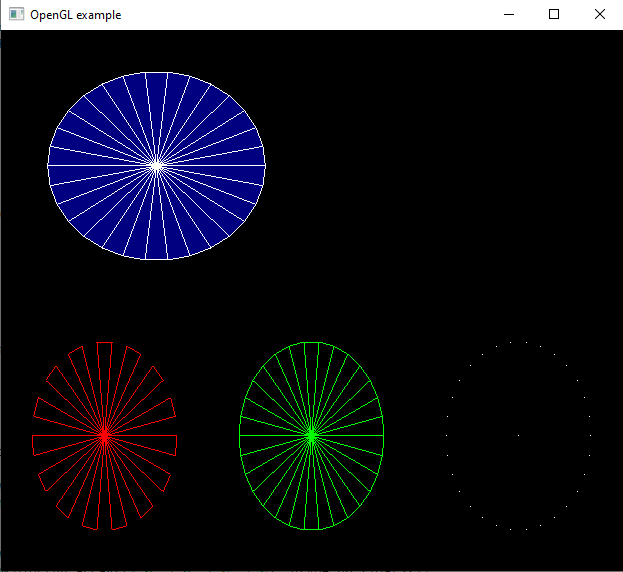

Here we can see our desired circle with wireframe in the top left corner, which was rendered with the TRIANGLE_FAN primitive, and in the bottom, the circle rendered with LINES, LINE_LOOP, and POINTS, respectively.

For <strong>Part 1</strong>, the code construction was done with ease, the only problem encountered being the fact that it is necessary to force the *vertex_indices* array to be <strong>dtype = uint32</strong> and for the *vertex_positions* array to be <strong>dtype = float32</strong>, or else the objects will not render. It is also important to remember to use radians with the *np.cos()* and *np.sin()* functions.

### Parte 2 - Quadrados loucos

Crie um programa que realize a animação descrita na imagem abaixo. Nela, há dois quadrados com as posições fixas no eixo x (fora da origem) e que giram no próprio eixo. Há também dois quadrados girando em torno da origem, mas em direções opostas. Cada triângulo possui uma cor diferente. Além disso, utilize os eventos da tecla + (QtCore.Qt.Key_Plus) e - (QtCore.Qt.Key_Minus) para, respectivamente, acelerar e diminuir a velocidade da rotação dos objetos. Você pode usar como base os notebooks ([27_Quadrado_com_transformacoes](27_Quadrado_com_transformacoes.ipynb)) e ([24_Eventos_do_teclado](24_Eventos_do_teclado.ipynb)).

![title](cg/images/ex7_squares.png)

In the following code we work with translation and rotation to construct a moving scene based on the above image. The orbiting and rotation speeds can be controlled with the + and - keys:

In [34]:
import glm
import numpy as np
import OpenGL.GL as gl
from PyQt5 import QtOpenGL, QtCore
from PyQt5.QtCore import QCoreApplication
from PyQt5.QtWidgets import QApplication

from cg.shader_programs.SimpleShaderProgram_v2 import SimpleShaderProgram
from cg.renderers.ModelRenderer_v2 import ModelRenderer
from cg.models.SquareMesh_v1 import SquareMesh

class MyWidget(QtOpenGL.QGLWidget):
    def initializeGL(self):
        
        # create square mesh
        square_mesh = SquareMesh(0.25, 0.255, 5, 5)
        
        # creat object responsible for loading objects into GPU and rendering
        self.squareRenderer = ModelRenderer(square_mesh.getVertexPositions(), vertex_indices=square_mesh.getVertexIndices())
        
        # create Simple Shader Program
        self.shaderProgram = SimpleShaderProgram()
        
        # Activates Shader Program to configure a single color for all vertices
        self.shaderProgram.bind()
        self.shaderProgram.useUniformColor(True)
        self.shaderProgram.release()

        # Retrieve the pointer to the shader program input
        position_loc = self.shaderProgram.getVertexPositionLoc()
        
        # Configure model data to be the shader program input
        self.squareRenderer.setVertexPositionLoc(position_loc)

        # Set movement variables
        self.angle1 = 0
        self.angle2 = 0
        self.speed1 = 0.05
        self.speed2 = 0.01
        self.radius = 0.7
        
    def paintGL(self):
        
        # set background color
        gl.glClearColor(0, 0, 0, 1)
        
        # clean background with the specified colorimpa o background com a cor especificada
        gl.glClear(gl.GL_COLOR_BUFFER_BIT)
        
        # activate Culling
        #gl.glEnable(gl.GL_CULL_FACE)
        
        # increment angles with the current step (rotation/orbit speed)
        self.angle1 += self.speed1 #central squares
        self.angle2 += self.speed2 #orbiting squares
        
        # activate the shader program
        self.shaderProgram.bind()
        
        # render squares
        self.renderRightCentralSquare()
        self.renderLeftCentralSquare()
        self.renderClockwiseSquare()
        self.renderCounterClockwiseSquare()
        
        # re-calls paintGL
        self.update()
    
    def renderRightCentralSquare(self):
        
        #set position in the view
        transl = glm.translate(glm.mat4(), glm.vec3(0.15,0,0))
        
        # calculate current rotation matrix
        model_matrix = glm.rotate(glm.mat4(), glm.radians(self.angle1), glm.vec3(0.0, 1.0, 0.0))
        model_matrix = transl * model_matrix
        self.shaderProgram.setUniformMVPMatrix(model_matrix)
        
        # set square color and render
        self.shaderProgram.setUniformColor(np.array([0.5, 0.0, 0.0, 1.0], dtype=np.float32))
        self.squareRenderer.render()
        
        # set wireframe color and render
#        self.shaderProgram.setUniformColor(np.array([1.0, 1.0, 1.0, 1.0], dtype=np.float32))
#        self.squareRenderer.renderWireframe()
    
    def renderLeftCentralSquare(self):
        
        #set position in the view
        transl = glm.translate(glm.mat4(), glm.vec3(-0.15,0,0))
        
        # calculate current rotation matrix
        model_matrix = glm.rotate(glm.mat4(), glm.radians(self.angle1), glm.vec3(0.0, 1.0, 0.0))
        model_matrix = transl * model_matrix
        self.shaderProgram.setUniformMVPMatrix(model_matrix)
        
        # set square color and render
        self.shaderProgram.setUniformColor(np.array([0.0, 0.5, 0.0, 1.0], dtype=np.float32))
        self.squareRenderer.render()
        
        # set wireframe color and render
#        self.shaderProgram.setUniformColor(np.array([1.0, 1.0, 1.0, 1.0], dtype=np.float32))
#        self.squareRenderer.renderWireframe()
    
    def renderClockwiseSquare(self):
        
        #update position in view (orbit)
        model_matrix = glm.translate(glm.mat4(), glm.vec3(self.radius*np.cos(self.angle2),self.radius*np.sin(self.angle2),0))
        self.shaderProgram.setUniformMVPMatrix(model_matrix)
        
        # set square color and render
        self.shaderProgram.setUniformColor(np.array([0.0,0.0,0.5,1.0], dtype=np.float32))
        self.squareRenderer.render()
        
        # set wireframe color and render
#        self.shaderProgram.setUniformColor(np.array([1.0,1.0,1.0,1.0], dtype=np.float32))
#        self.squareRenderer.renderWireframe()
        
        
    def renderCounterClockwiseSquare(self):
        
        #update position in view (orbit)
        model_matrix = glm.translate(glm.mat4(), glm.vec3(self.radius*np.cos(-self.angle2),self.radius*np.sin(-self.angle2),0))
        self.shaderProgram.setUniformMVPMatrix(model_matrix)
        
        # set square color and render
        self.shaderProgram.setUniformColor(np.array([1.0,1.0,0.0,1.0], dtype=np.float32))
        self.squareRenderer.render()
        
        # set wireframe color and render
#        self.shaderProgram.setUniformColor(np.array([1.0,1.0,1.0,1.0], dtype=np.float32))
#        self.squareRenderer.renderWireframe()
    
    # Key Press Event descriptions
    def keyPressEvent(self, event):
        super(MyWidget, self).keyPressEvent(event)
        
        if event.key() == (QtCore.Qt.Key_Plus):
            self.speedChange('up')
        if event.key() == (QtCore.Qt.Key_Minus):
            self.speedChange('down')
    
    # Define speed change 
    def speedChange(self, direction):       
        if direction == 'up':
            self.updateSpeed(speed1=0.01, speed2=0.001)
        if direction == 'down':
            self.updateSpeed(speed1=-0.01, speed2=-0.001)
    
    # Update speed variables
    def updateSpeed(self,speed1 = 0, speed2=0):
        self.speed1 += speed1
        self.speed2 += speed2
        
    def resizeGL(self, width, height):
        gl.glViewport(0, 0, width, height)

def main():
    import sys

    #Create Qt application
    app = QCoreApplication.instance()
    if app is None:
        app = QApplication(sys.argv)

    #Specify the OpenGL context
    glformat = QtOpenGL.QGLFormat()
    glformat.setVersion(3, 3)
    glformat.setDoubleBuffer(True)
    glformat.setProfile(QtOpenGL.QGLFormat.CoreProfile)
    
    #Create rendering window
    w = MyWidget(glformat)
    w.resize(640, 480)
    w.setWindowTitle('OpenGL example')
    w.show()
    
    sys.exit(app.exec_())

if __name__ == '__main__':
    main()

SystemExit: 0

After running the above code, we succesfully rendered the following window:
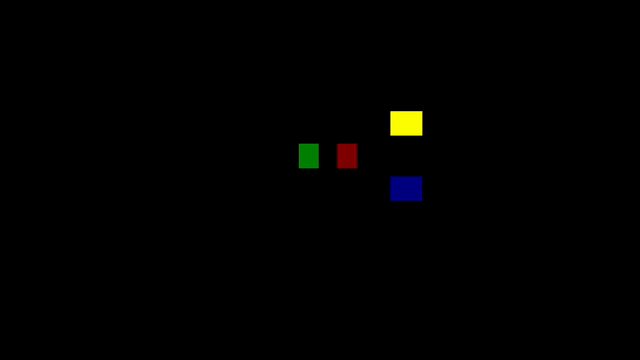

As we can see, the movements are correct, and the speed can be altered with the keys as desired. The construction of this code was very direct. The main concept learned with this exercise was the fundamental difference between <strong>rotation</strong> and <strong>translation</strong>. Also it was important to establish different value "steps" for speed increase/decrease: one for the orbiting squares and another for the rotating square. Without this it was hard to see the speed change of the center squares.

### Parte 3 - Posicionando a lua

Complete a definição das funções 'renderMoonOrbit()' e 'renderMoon()' do código abaixo para renderizar dois objetos. O primeiro objeto é a orbita da lua acompanhando a movimentação da Terra. O segundo objeto é a lua girando em torno da Terra. Também é preciso criar na função 'initializeGL()' duas variáveis (semelhantes às variáveis 'self.earthOrbit' e 'self.earthPlanet') responsáveis por armazenar as informações gráficas da lua e da sua órbita. A animação final deve ser semelhante à imagem abaixo.

Você pode usar como base o notebook ([27_Quadrado_com_transformacoes](27_Quadrado_com_transformacoes.ipynb)).

![title](cg/images/ex7_earth_moon.png)

In the following code, we setup a scene with a sun and two orbits: the moon and the earth.

In [36]:
import glm
import time
import math
import numpy as np
import OpenGL.GL as gl
from PyQt5 import QtOpenGL, QtCore
from PyQt5.QtCore import QCoreApplication
from PyQt5.QtWidgets import QApplication

from cg.shader_programs.SimpleShaderProgram_v2 import SimpleShaderProgram
from cg.renderers.ModelRenderer_v2 import ModelRenderer
from cg.models.SphereMesh_v1 import SphereMesh
from cg.models.OrbitPolygon import OrbitPolygon

AU = 1.496E8
planet_scale_factor = 1500.0
moon_scale_factor = planet_scale_factor * 0.05
sun_scale_factor = 50

# Sun information Class
class SunInfo:
    def __init__(self, color, diameter):
        
        self.color = color
        self.diameter = (diameter / AU) * sun_scale_factor
        self.radius = self.diameter / 2.0

# Planet information Class
class PlanetInfo:
    def __init__(self, color, diameter, orbitalPeriod, orbitalInclination, orbitSemiMajorAxis, orbitSemiMinorAxis, orbitFocus):
        
        earth_days = 365.2
        
        self.color = color
        self.diameter = (diameter / AU) * planet_scale_factor
        self.radius = self.diameter / 2.0
        self.velocity = earth_days / orbitalPeriod
        
        self.orbitalPeriod = orbitalPeriod
        self.orbitalInclination = orbitalInclination 
        self.orbitSemiMajorAxis = orbitSemiMajorAxis
        self.orbitSemiMinorAxis = orbitSemiMinorAxis
        self.orbitFocus = orbitFocus

# creat dict with sun, planet, and moon info
PlanetarySheet = {
       'sun': SunInfo(np.array([1.00, 1.00, 0.00, 1.00]), 1391900),
       'earth': PlanetInfo(np.array([0.61, 0.79, 0.37,1.00]), 12742, 365.2, 1.57, 1.0027, 1.0025, 0.0167),
       'moon': PlanetInfo(np.array([0.50, 0.50, 0.50,1.00]), 3475, 27.3, 5.1, 0.0025718 * moon_scale_factor, 0.0021479 * moon_scale_factor, 0.00014537)
       }

# Graphic information class
class GraphicObject:
    def __init__(self):
        self.model = None
        self.renderer = None
        self.modelMatrix = glm.mat4()
        self.color = np.array([1.0, 1.0, 1.0, 1.0])

        
class MyWidget(QtOpenGL.QGLWidget):

    def initializeGL(self):
        
        # define global transformation
        # objects do not fit in the rendering volume in there original size 
        # So they must be resized to be smaller
        self.globalTransform = glm.scale(glm.mat4(), glm.vec3(0.8, 0.8, 0.8))
        
        # create Simple Shader Programcria um shader program simples     
        self.shaderProgram = SimpleShaderProgram()
        
        # Retrieve the pointer to the shader program input
        position_loc = self.shaderProgram.getVertexPositionLoc()
        
        # Activates Shader Program to configure a single color for all vertices
        self.shaderProgram.bind()
        self.shaderProgram.useUniformColor(True)
        self.shaderProgram.release()

        # creates spheric triangle mech for the sun, moon, and planet
        sphere_mesh = SphereMesh(1.0, 30, 30)
        sphere_renderer = ModelRenderer(sphere_mesh.getVertexPositions(), vertex_indices=sphere_mesh.getVertexIndices())
        sphere_renderer.setVertexPositionLoc(position_loc)
        
        # create object to store planet orbit info
        planet_info = PlanetarySheet['earth']
        self.earthOrbit = GraphicObject()
        self.earthOrbit.model = OrbitPolygon(planet_info.orbitSemiMajorAxis, planet_info.orbitSemiMinorAxis, planet_info.orbitFocus, 50)
        self.earthOrbit.renderer = ModelRenderer(self.earthOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.earthOrbit.renderer.setVertexPositionLoc(position_loc)
        self.earthOrbit.color = planet_info.color
        self.earthOrbit.modelMatrix = self.globalTransform 
    
        # creat object to store planet info
        self.earthPlanet = GraphicObject()
        self.earthPlanet.model = sphere_mesh
        self.earthPlanet.renderer = sphere_renderer
        self.earthPlanet.color = PlanetarySheet['earth'].color
        
        # create object to store Sun info
        self.sun = GraphicObject()
        self.sun.model = sphere_mesh
        self.sun.renderer = sphere_renderer
        self.sun.color = PlanetarySheet['sun'].color
        self.sun.modelMatrix = glm.scale(glm.mat4(), glm.vec3(PlanetarySheet['sun'].radius, PlanetarySheet['sun'].radius, PlanetarySheet['sun'].radius))
        
        # create object to store moon orbit info
        moon_info = PlanetarySheet['moon']
        self.moonOrbit = GraphicObject()
        self.moonOrbit.model = OrbitPolygon(moon_info.orbitSemiMajorAxis, moon_info.orbitSemiMinorAxis, moon_info.orbitFocus, 50)
        self.moonOrbit.renderer = ModelRenderer(self.moonOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.moonOrbit.renderer.setVertexPositionLoc(position_loc)
        self.moonOrbit.color = moon_info.color
        self.moonOrbit.modelMatrix = self.globalTransform 
    
        # create object to store moon info
        self.moon = GraphicObject()
        self.moon.model = sphere_mesh
        self.moon.renderer = sphere_renderer
        self.moon.color = PlanetarySheet['moon'].color
    
         # stores program start time
        self.startTime = time.time()
    
    def paintGL(self):
        
        # set background color
        gl.glClearColor(0, 0, 0, 1)
        
        # clean background with the specified color
        gl.glClear(gl.GL_COLOR_BUFFER_BIT | gl.GL_DEPTH_BUFFER_BIT)
        
        # activate depth test
        gl.glEnable(gl.GL_DEPTH_TEST);
        
        # calculate the current execution time
        self.currentTime = time.time()
        time_elapsed = self.currentTime - self.startTime
        
        # activate shader program
        self.shaderProgram.bind()

        # render objects 
        self.renderSun()
        self.renderEarthOrbit()
        self.renderEarthPlanet(time_elapsed)
        self.renderMoonOrbit(time_elapsed)
        self.renderMoon(time_elapsed)
        
        # deactivate shader program
        self.shaderProgram.release()
        
        # re-call paintGL
        self.update()
    
    def resizeGL(self, width, height):

        # update rendering area to be the entire window
        gl.glViewport(0, 0, width, height)
        
    def renderSun(self):
    
        # update shader with the transformation and Sun color
        self.shaderProgram.setUniformMVPMatrix(self.sun.modelMatrix)
        self.shaderProgram.setUniformColor(self.sun.color)
        
        # render the Sun
        self.sun.renderer.render()
    
    def renderEarthOrbit(self):
        
        # update shader with the transformation and Earth Orbit Color
        self.shaderProgram.setUniformMVPMatrix(self.earthOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.earthOrbit.color)
        
        # render earth orbit
        self.earthOrbit.renderer.render()
        
    def renderEarthPlanet(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05
        
        # get Planet position on earth orbit
        planet_info = PlanetarySheet['earth']
        x, y = self.earthOrbit.model.getPositionAt(angle * planet_info.velocity)
        
        # create translation matrix to update planet position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep planet at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(planet_info.radius, planet_info.radius, planet_info.radius))
        
        # calculate final planet transformation matrix
        self.earthPlanet.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.earthPlanet.modelMatrix)
        self.shaderProgram.setUniformColor(self.earthPlanet.color)
        
        # render the planet
        self.earthPlanet.renderer.render()
    
    def renderMoonOrbit(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05 #get current angle
        
        # get moon orbit position on earth orbit
        moon_info = PlanetarySheet['moon'] #get moon info
        planet_info = PlanetarySheet['earth'] #get earth info
        x, y = self.earthOrbit.model.getPositionAt(angle * planet_info.velocity) #get new coordinates for translation
        
        transl_moonOrbit_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0)) #calculate translation matrix
        self.moonOrbit.modelMatrix = self.globalTransform * transl_moonOrbit_pos #calulate new position 
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.moonOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.moonOrbit.color)
        
        # render the moon orbit
        self.moonOrbit.renderer.render()
        
    
    def renderMoon(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05 #get current angle
        
        # get moon position on moon orbit
        moon_info = PlanetarySheet['moon'] #get moon info
        planet_info = PlanetarySheet['earth'] #get earth info
        x, y = self.earthOrbit.model.getPositionAt(angle * planet_info.velocity) # new coordinates due to orbit translation
        x1, y1 = self.moonOrbit.model.getPositionAt(angle * moon_info.velocity) # new coordinates due to orbit around earth
        
        # add both translations into one
        x= x + x1
        y = y + y1
        
        # create translation matrix to update moon position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep moon at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(moon_info.radius, moon_info.radius, moon_info.radius))
        
        # calculate final moon transformation matrix
        self.moon.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the moon color
        self.shaderProgram.setUniformMVPMatrix(self.moon.modelMatrix)
        self.shaderProgram.setUniformColor(self.moon.color)
        
        # render the planet
        self.moon.renderer.render()
        pass
    
def main():
    import sys

    #create Qt application
    app = QCoreApplication.instance()
    if app is None:
        app = QApplication(sys.argv)

    #specify openGL context
    glformat = QtOpenGL.QGLFormat()
    glformat.setVersion(3, 3)
    glformat.setDoubleBuffer(True)
    glformat.setProfile(QtOpenGL.QGLFormat.CoreProfile)
    
    #create rendering window
    w = MyWidget(glformat)
    w.resize(600, 600)
    w.setWindowTitle('Solar System')
    w.show()
    
    output = app.exec_()
    sys.exit(output)
    
if __name__ == '__main__':
    main()

SystemExit: 0

After running the above code, we succesfully obtained the following window:
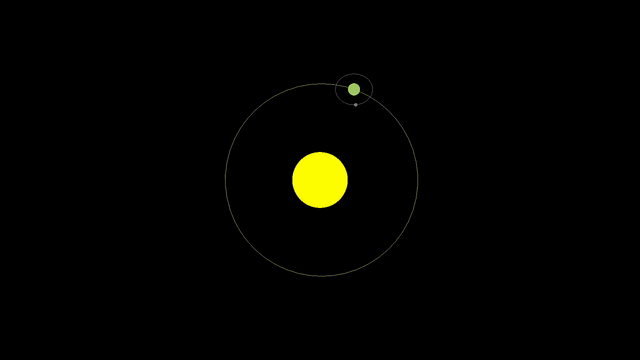

This code was also constructed with relative ease. The two things that are worth noting and important to remember are:
<ul><li>The translation of the Moon Orbit is the same as the translation of the Earth</ul></li>
<ul><li>The moon's movement is made up of two seperate movements: translation around the earth (moon's orbit) and translation around the sun (earth's orbit)</ul></li>